In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

### Load Data

In [2]:
from glob import glob 
glob('./*')

['./Predict_bad_loan.ipynb', './Loan_Dataset.csv', './variable_descriptions']

In [3]:
df = pd.read_csv('Loan_Dataset.csv')

In [4]:
df.head()

,id,grade,annual_income,short_employee,emp_length_num,home_ownership,Debt-To-Income Ratio,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   grade                  20000 non-null  object 
 2   annual_income          20000 non-null  int64  
 3   short_employee         20000 non-null  int64  
 4   emp_length_num         20000 non-null  int64  
 5   home_ownership         18509 non-null  object 
 6   Debt-To-Income Ratio   19846 non-null  float64
 7   purpose                20000 non-null  object 
 8   term                   20000 non-null  object 
 9   last_delinq_none       20000 non-null  int64  
 10  last_major_derog_none  574 non-null    float64
 11  revol_util             20000 non-null  float64
 12  total_rec_late_fee     20000 non-null  float64
 13  od_ratio               20000 non-null  float64
 14  bad_loan               20000 non-null  int64  
dtypes:

### Data Cleaning - Missing Data

In [6]:
#last_major_derog_none - 1 when the loaner has a bad rating for at least 90 days.
df.last_major_derog_none.value_counts()

1.0    436
0.0    138
Name: last_major_derog_none, dtype: int64

In [7]:
#decide how to deal with missing values

#since the majority of the values in last_major_derog_none are missing, dropping the whole column
df.drop(columns= ['last_major_derog_none'], inplace=True)
df.shape

(20000, 14)

In [8]:
df.fillna('NA',inplace=True)

In [9]:
df.home_ownership.value_counts()

MORTGAGE    9844
RENT        7052
OWN         1613
NA          1491
Name: home_ownership, dtype: int64

In [10]:
#is missing values in home_ownership related to the target, bad_loan?
#if yes, then we should not just drop all the rows with missing home_ownership values
#if no, then we can drop those rows
#use chi-square test to test

#table = df.groupby(['bad_loan','home_ownership']).id.agg(['count'])
table = pd.crosstab(df.bad_loan, df.home_ownership,margins=True, margins_name='Total')

table

home_ownership,MORTGAGE,NA,OWN,RENT,Total
bad_loan,,,,,
0,8136,1199,1297,5368,16000
1,1708,292,316,1684,4000
Total,9844,1491,1613,7052,20000


In [11]:
table_2 = list(table.loc[[0,1],'NA']), list(table.loc[[0,1],'Total'])
table_2

([1199, 292], [16000, 4000])

In [12]:
chi2_stat, p_value, dof, expected_values = chi2_contingency(table_2)
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected values table:")
print(expected_values)

if p_value < 0.05:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Reject the null hypothesis. The number of missing values in home_ownership and bad_loan are dependent. Observations with missing home_ownership values may not be dropped.')
else:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Fail to reject the null hypothesis. The number of missing values in home_ownership and bad_loan are independent. Observations with missing home_ownership values may be dropped. Remaining observations will still represent the population.')

Chi-square statistic: 0.125226721135046
P-value: 0.7234334047142614
Degrees of freedom: 1
Expected values table:
[[ 1193.23014285   297.76985715]
 [16005.76985715  3994.23014285]]
Chi-square Statistic is 0.125226721135046. P-value is 0.7234334047142614. Fail to reject the null hypothesis. The number of missing values in home_ownership and bad_loan are independent. Observations with missing home_ownership values may be dropped. Remaining observations will still represent the population.


In [13]:
row_num_be4 = df.shape[0]
row_num_to_drop = df.home_ownership.value_counts()['NA']

df = df[df.home_ownership!='NA']
row_num_aft = df.shape[0]

assert row_num_aft == row_num_be4 - row_num_to_drop

In [14]:
#is missing values in Debt-To-Income Ratio related to the target, bad_loan?
#if yes, then we should not just drop all the rows with missing home_ownership values
#if no, then we can drop those rows
#use chi-square test to test

dti_ratio = df['Debt-To-Income Ratio'].apply(lambda x: 'non-NA' if x != 'NA' else 'NA')
table_3 = pd.crosstab(df.bad_loan, dti_ratio, margins=True, margins_name='Total')
table_3

Debt-To-Income Ratio,NA,non-NA,Total
bad_loan,,,
0,113,14688,14801
1,25,3683,3708
Total,138,18371,18509


In [15]:
chi2_stat, p_value, dof, expected_values = chi2_contingency(table_3)
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected values table:")
print(expected_values)

if p_value < 0.05:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are dependent. Observations with missing debt-to-income_ratio values may not be dropped.')
else:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Fail to reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are independent. Observations with missing debt-to-income_ratio values may be dropped. Remaining observations will still represent the population.')

Chi-square statistic: 0.31912447666432636
P-value: 0.988546412334345
Degrees of freedom: 4
Expected values table:
[[  110.35377384 14690.64622616 14801.        ]
 [   27.64622616  3680.35377384  3708.        ]
 [  138.         18371.         18509.        ]]
Chi-square Statistic is 0.31912447666432636. P-value is 0.988546412334345. Fail to reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are independent. Observations with missing debt-to-income_ratio values may be dropped. Remaining observations will still represent the population.


In [16]:
row_num_be4 = df.shape[0]
row_num_to_drop = df['Debt-To-Income Ratio'].value_counts()['NA']

df = df[df['Debt-To-Income Ratio']!='NA']
row_num_aft = df.shape[0]

assert row_num_aft == row_num_be4 - row_num_to_drop

In [17]:
#change Debt-To-Income Ratio and last_delinq_none to float
df['Debt-To-Income Ratio'] = df['Debt-To-Income Ratio'].astype(float)
df['last_delinq_none'] = df['last_delinq_none'].astype(object)

In [18]:
#clean up term values
df.term.value_counts()
df.term = df.term.apply(lambda x: '36 months' if x == ' 36 Months' else x)
df.term = df.term.apply(lambda x: '36 months' if x == ' 36 months' else x)
df.term = df.term.apply(lambda x: '60 months' if x == ' 60 months' else x)
df.term.value_counts()

36 months    13754
60 months     4617
Name: term, dtype: int64

In [19]:
#after dropping all the rows with missing info, there is no more missing value
(df=='NA').sum(axis=0).sum()

0

### Data Cleaning - Duplicates

In [20]:
df.duplicated().sum()

0

In [21]:
df.describe()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,1.837100e+04,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000
mean,7.594628e+06,73421.273257,0.112297,6.827609,16.590894,56.001801,0.293404,0.504941,0.200479
std,1.609952e+06,45612.958798,0.315740,3.769322,7.582902,43.411698,3.140913,0.287800,0.400370
min,5.860400e+05,8412.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000077,0.000000
25%,6.206280e+06,47000.000000,0.000000,3.000000,10.850000,38.750000,0.000000,0.257495,0.000000
50%,7.379923e+06,65000.000000,0.000000,7.000000,16.220000,57.100000,0.000000,0.507883,0.000000
75%,8.776061e+06,88000.000000,0.000000,11.000000,22.060000,74.000000,0.000000,0.753875,0.000000
max,1.145464e+07,1000000.000000,1.000000,11.000000,34.990000,5010.000000,96.466600,0.999894,1.000000


According to the variable_description file:

Short _ emp - 1 when the borrower has been employed for 1 year or less.
Emp _ length _ num - Number of years worked (in years). It ranges from 0 to 10, 
where 0 means less than a year and 10 means a decade or more.

mmm, i see max is 11 in emp_length_num. not a big deal??

In [22]:
#double check to make sure obs with value 1 in short_employee have emp_length_num <=1

assert (df[df.short_employee==1]['emp_length_num']<=1).mean() ==1

### Data Cleaning - Outliers

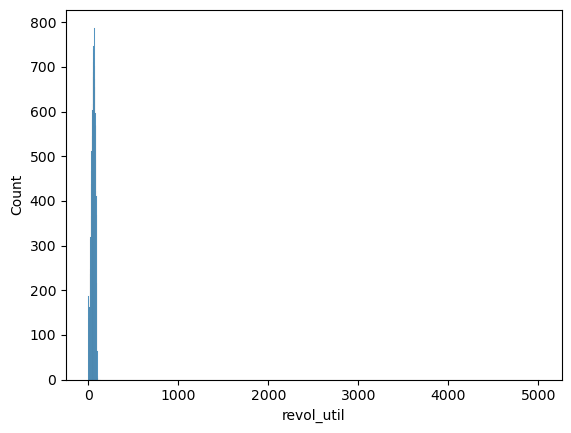

In [23]:
#outliers in revol_util and total_rec_late_fee?
sns.histplot(x='revol_util',data=df)
plt.show()

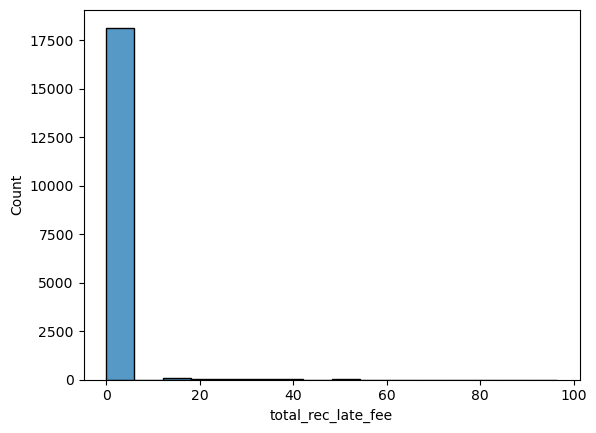

In [24]:
sns.histplot(x='total_rec_late_fee',data=df)
plt.show()

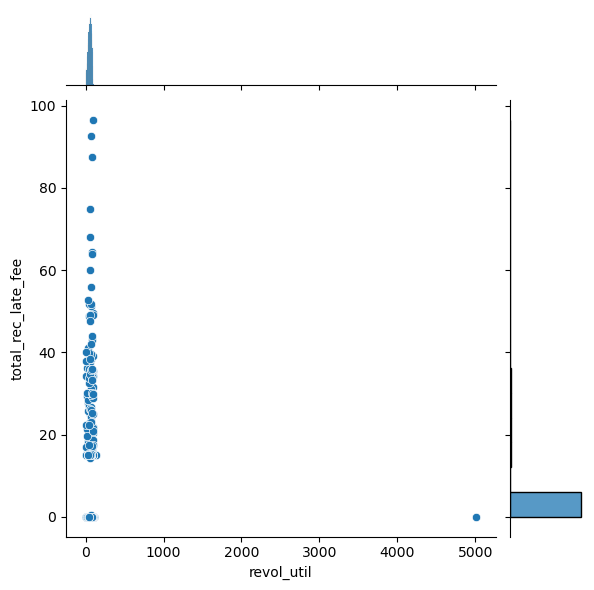

In [25]:
#outliers in revol_util and total_rec_late_fee?
sns.jointplot(x='revol_util',y='total_rec_late_fee',data=df);
plt.show()

In [26]:
df.revol_util.nlargest(10)

100      5010.0
2643      128.1
7880      112.9
19809     109.1
11712     107.7
7208      106.9
16563     106.1
12516     105.8
4948      105.3
17394     103.5
Name: revol_util, dtype: float64

In [27]:
df = df[df.revol_util!=df.revol_util.nlargest(10).iloc[0]]
df.shape

(18370, 14)

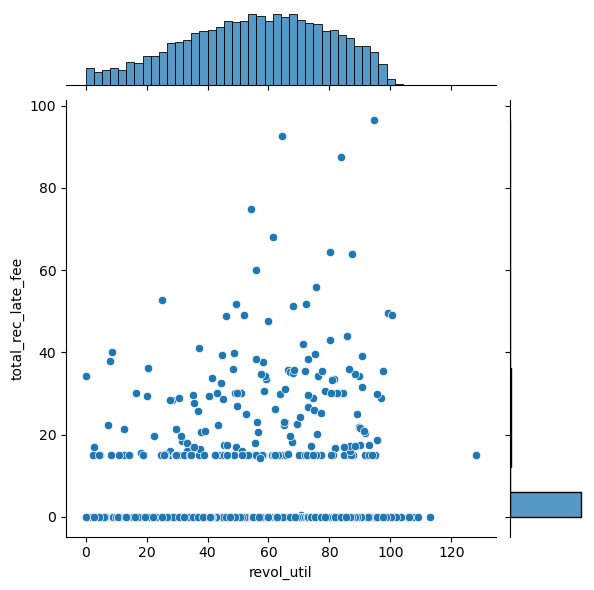

In [28]:
sns.jointplot(x='revol_util',y='total_rec_late_fee',data=df);

In [29]:
df.reset_index(drop=True, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18370 entries, 0 to 18369
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    18370 non-null  int64  
 1   grade                 18370 non-null  object 
 2   annual_income         18370 non-null  int64  
 3   short_employee        18370 non-null  int64  
 4   emp_length_num        18370 non-null  int64  
 5   home_ownership        18370 non-null  object 
 6   Debt-To-Income Ratio  18370 non-null  float64
 7   purpose               18370 non-null  object 
 8   term                  18370 non-null  object 
 9   last_delinq_none      18370 non-null  object 
 10  revol_util            18370 non-null  float64
 11  total_rec_late_fee    18370 non-null  float64
 12  od_ratio              18370 non-null  float64
 13  bad_loan              18370 non-null  int64  
dtypes: float64(4), int64(5), object(5)
memory usage: 2.0+ MB


Loan default is a rare case:

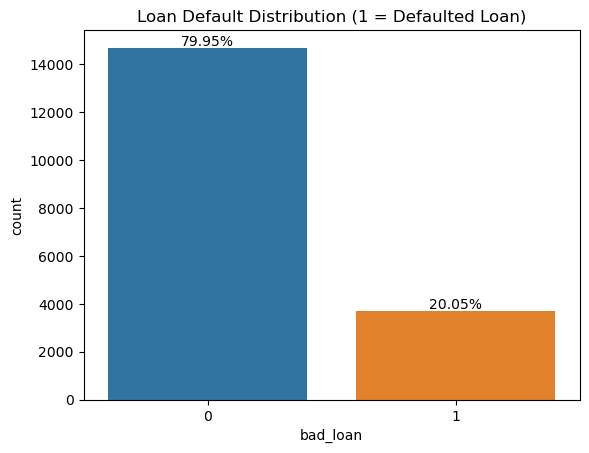

In [31]:
total_count = df.bad_loan.size

ax = sns.countplot(x='bad_loan', data=df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, f'{height/total_count*100:.2f}%', ha='center')

plt.title('Loan Default Distribution (1 = Defaulted Loan)')
plt.show()

### Visualization of Categorical Features' Distributions

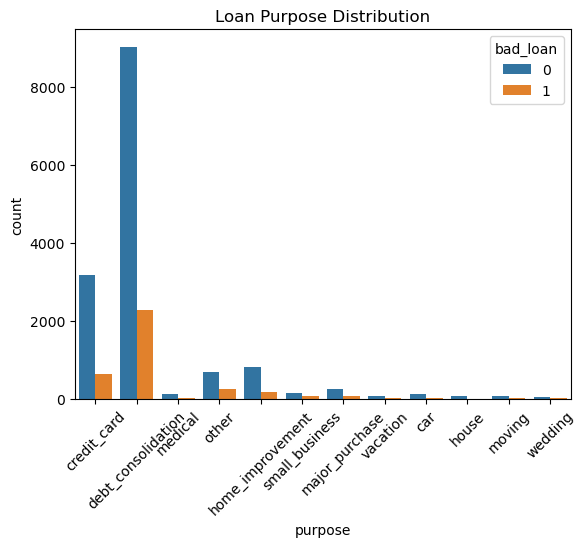

In [32]:
sns.countplot(x=df.purpose, hue=df.bad_loan);
plt.xticks(rotation=45)
plt.title('Loan Purpose Distribution');

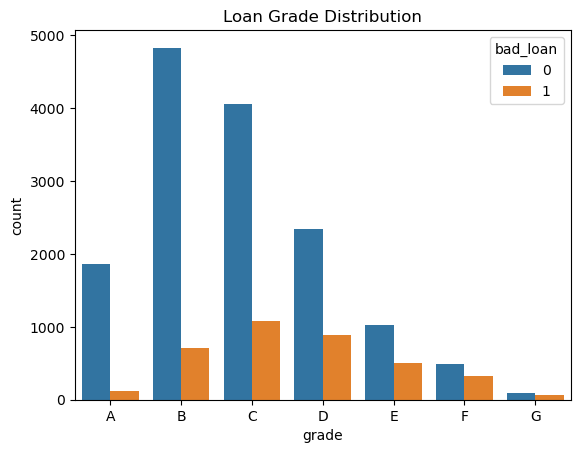

In [33]:
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(x=df.grade, hue=df.bad_loan, order=grade_order);
plt.title('Loan Grade Distribution');

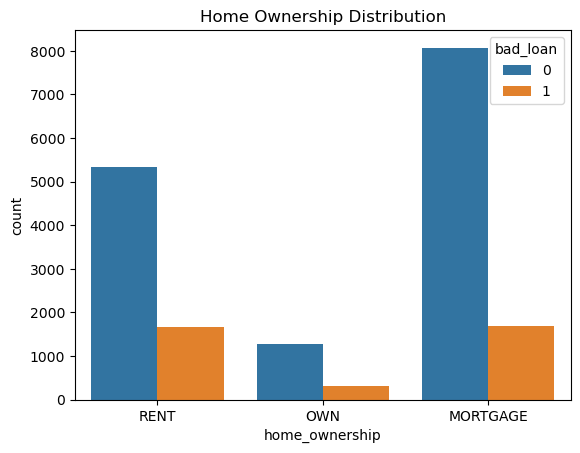

In [34]:
sns.countplot(x=df.home_ownership, hue=df.bad_loan);
plt.title('Home Ownership Distribution');

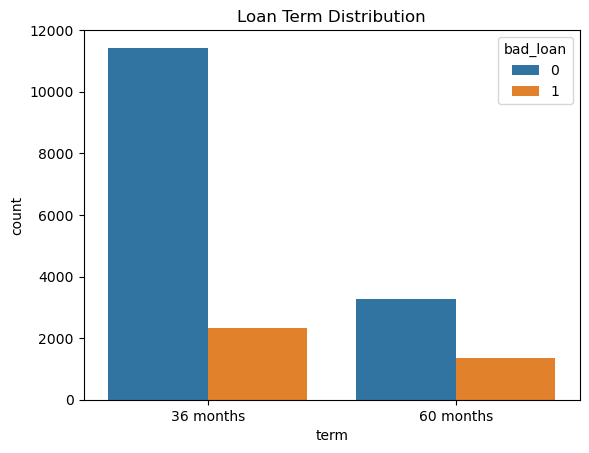

In [35]:
sns.countplot(x=df.term, hue=df.bad_loan);
plt.title('Loan Term Distribution');

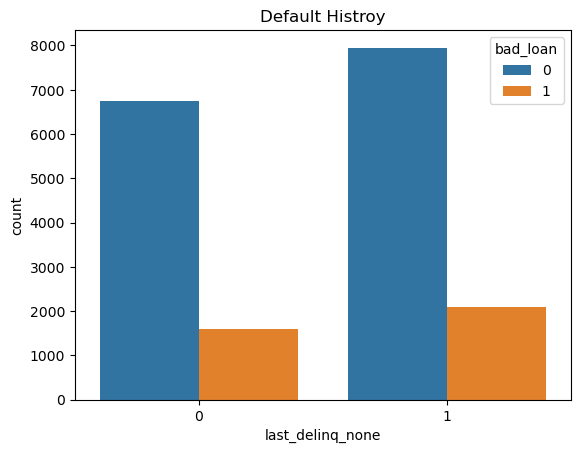

In [36]:
#Last _ delinq _ none - 1 when the debit has been in default at least once.
sns.countplot(x=df.last_delinq_none, hue=df.bad_loan);
plt.title('Default Histroy');

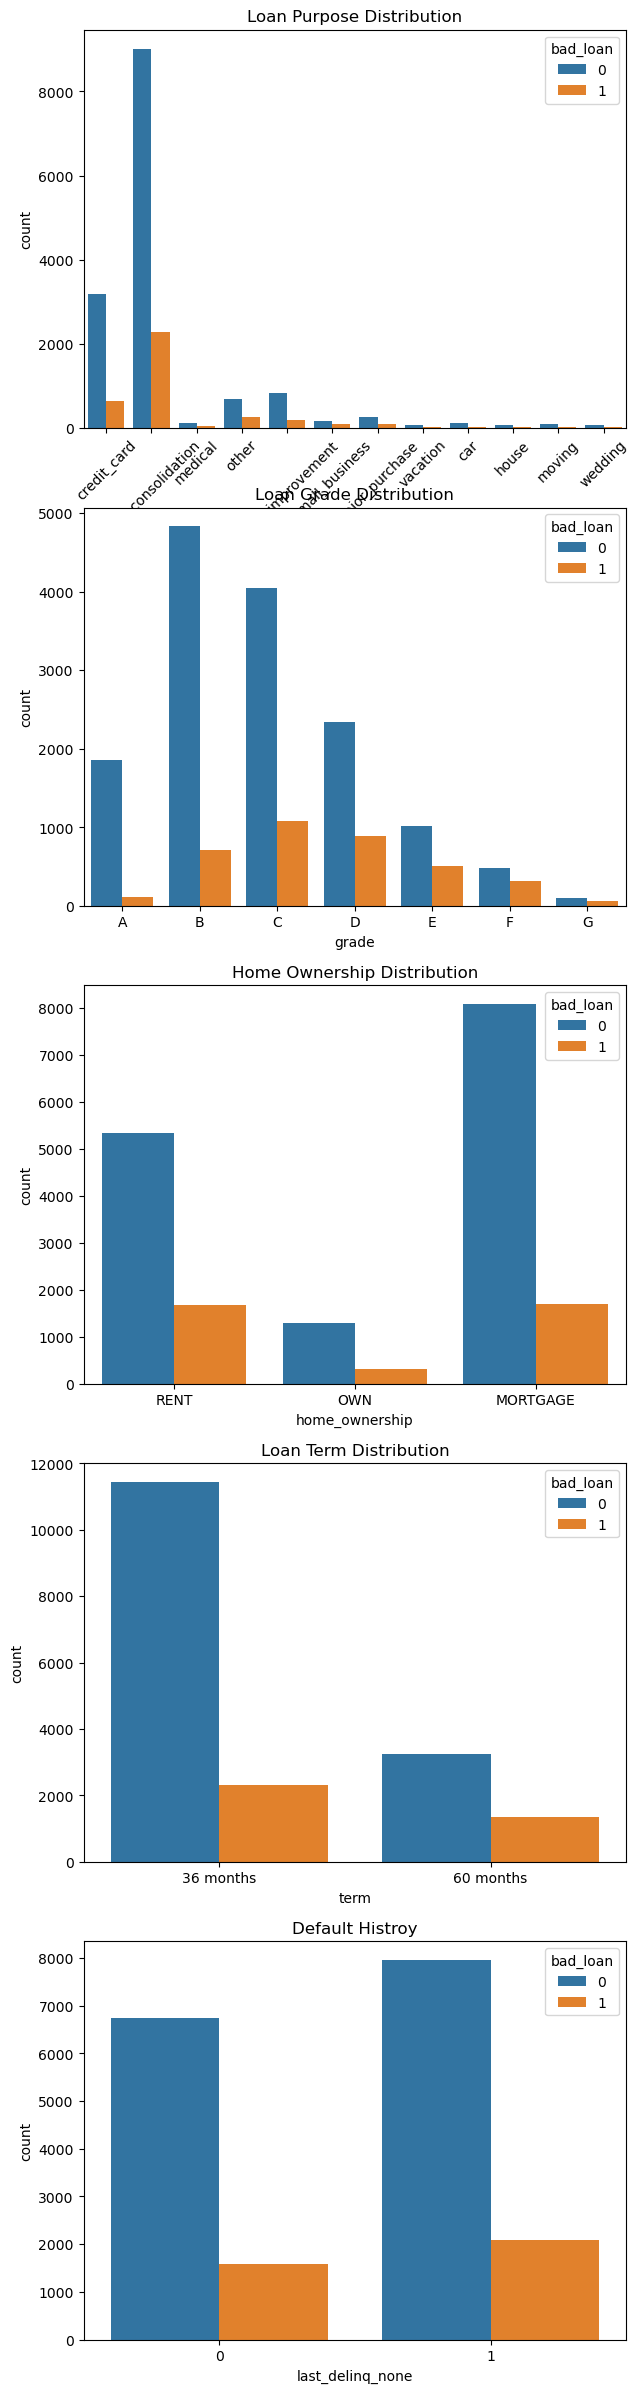

In [37]:
fig,ax = plt.subplots(5,1,figsize=(7,30))

sns.countplot(x=df.purpose, hue=df.bad_loan, ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Loan Purpose Distribution');

sns.countplot(x=df.grade, hue=df.bad_loan, order=grade_order, ax=ax[1]);
ax[1].set_title('Loan Grade Distribution');

sns.countplot(x=df.home_ownership, hue=df.bad_loan, ax=ax[2]);
ax[2].set_title('Home Ownership Distribution');

sns.countplot(x=df.term, hue=df.bad_loan, ax=ax[3]);
ax[3].set_title('Loan Term Distribution');

sns.countplot(x=df.last_delinq_none, hue=df.bad_loan, ax=ax[4]);
ax[4].set_title('Default Histroy');


### Visualization of Continuous Features' Distributions

Histograms

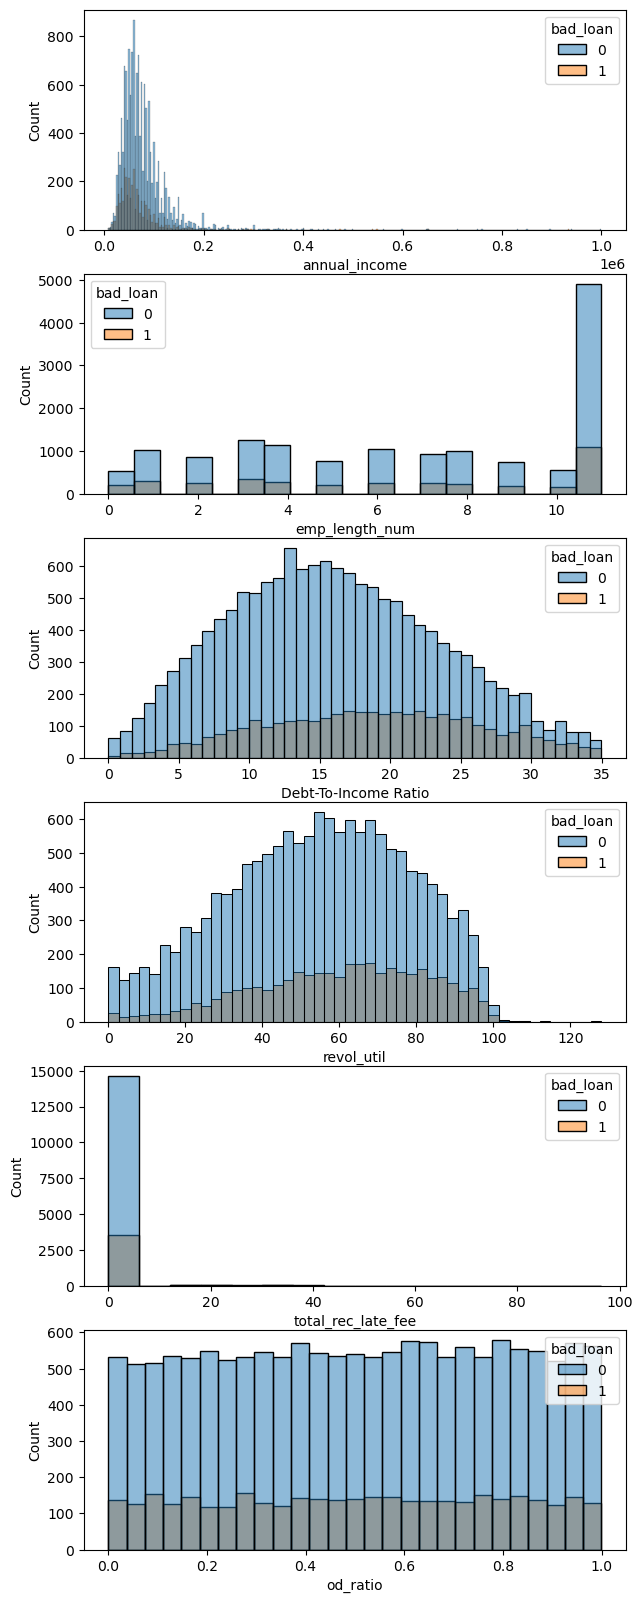

In [38]:
fig,ax = plt.subplots(6,1,figsize=(7,20))

sns.histplot(x='annual_income',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[0]);

sns.histplot(x='emp_length_num',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[1]);

sns.histplot(x='Debt-To-Income Ratio',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[2]);

sns.histplot(x='revol_util',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[3]);

sns.histplot(x='total_rec_late_fee',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[4]);

sns.histplot(x='od_ratio',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[5]);

Boxplots

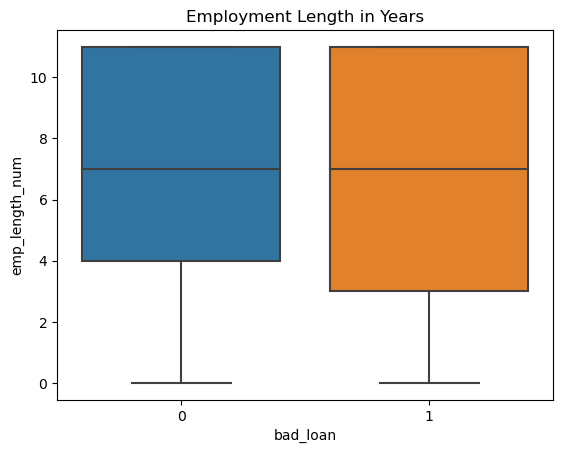

In [39]:
sns.boxplot(y='emp_length_num',
                x ='bad_loan',
                data=df);
plt.title('Employment Length in Years')
plt.show()

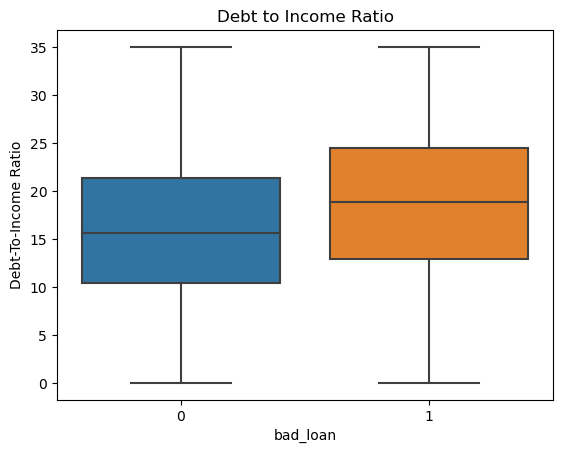

In [40]:
sns.boxplot(y='Debt-To-Income Ratio',
                x='bad_loan',
                data=df);
plt.title('Debt to Income Ratio')
plt.show()

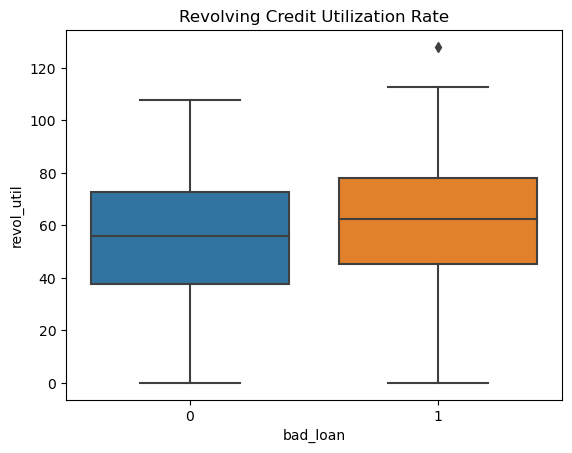

In [41]:
sns.boxplot(y='revol_util',
                x = 'bad_loan', 
                data=df);
plt.title('Revolving Credit Utilization Rate')
plt.show()

In [42]:
df.total_rec_late_fee[df.total_rec_late_fee != 0].sort_values()

10246     0.0100
8570      0.0100
12960     0.3500
14721    14.2350
3456     14.9394
          ...   
9672     68.1100
12936    74.9400
7201     87.5200
12709    92.5200
16034    96.4666
Name: total_rec_late_fee, Length: 212, dtype: float64

In [43]:
total_rec_late_fee_not0_df = df[df.total_rec_late_fee != 0]

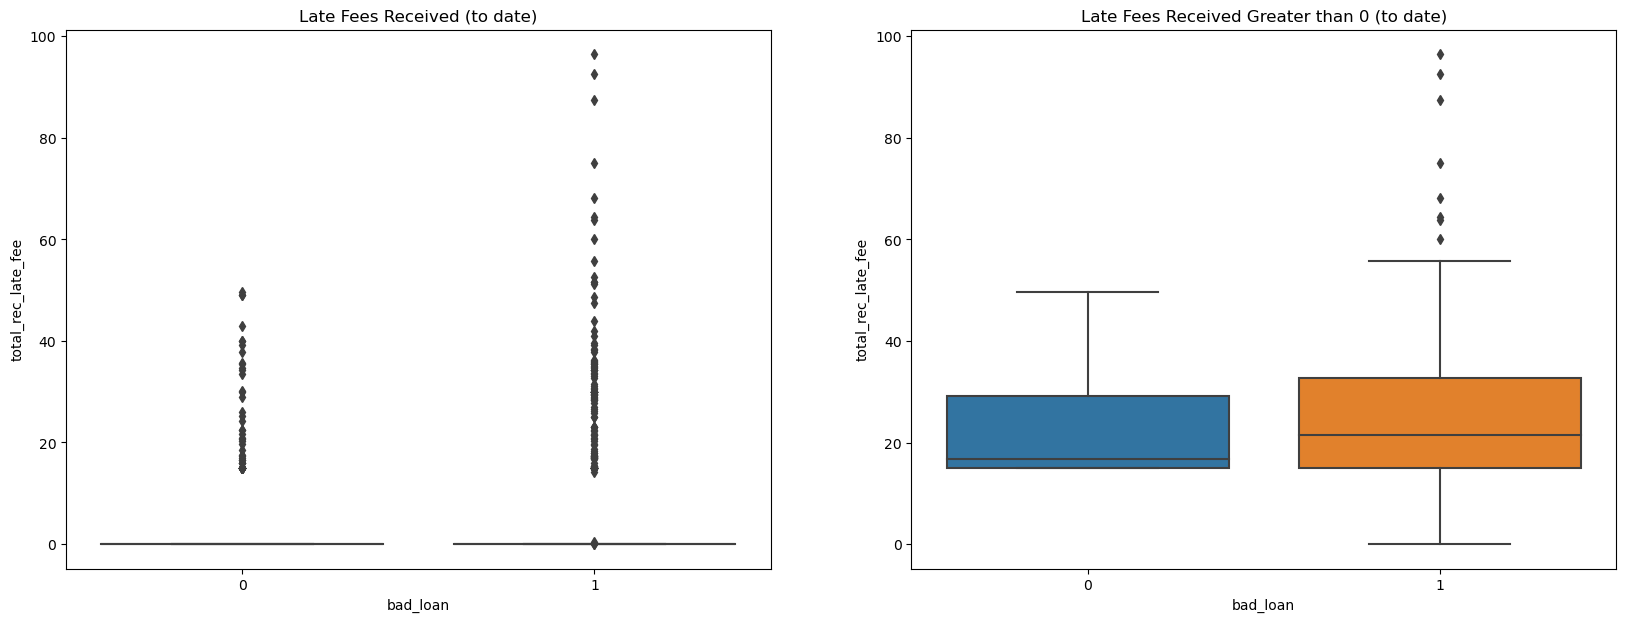

In [44]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

sns.boxplot(y='total_rec_late_fee',
            x = 'bad_loan', 
            data=df,
            ax=ax[0]);
ax[0].set_title('Late Fees Received (to date)');

#'zoom in' to late fees that are not zero
sns.boxplot(y='total_rec_late_fee',
            x = 'bad_loan', 
            data=total_rec_late_fee_not0_df,
            ax=ax[1]);
ax[1].set_title('Late Fees Received Greater than 0 (to date)');

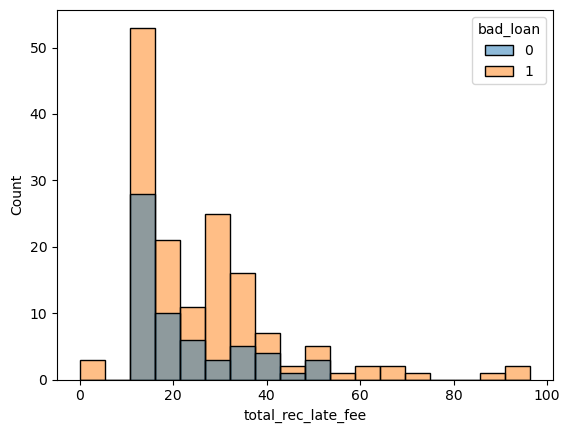

In [45]:
sns.histplot(x='total_rec_late_fee',
                hue = 'bad_loan', 
                data=total_rec_late_fee_not0_df)
plt.show()

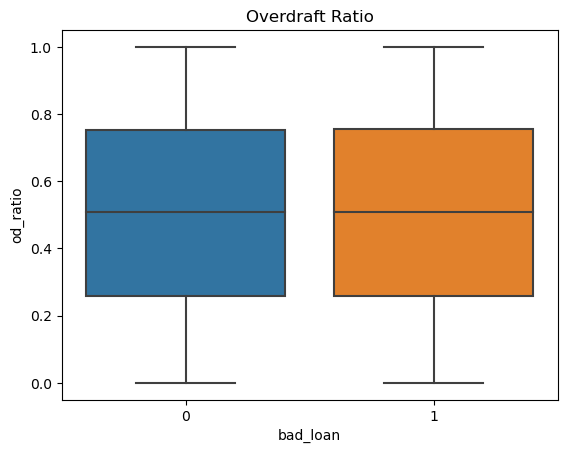

In [46]:
sns.boxplot(y='od_ratio',
                x = 'bad_loan', 
                data=df);
plt.title('Overdraft Ratio')
plt.show()

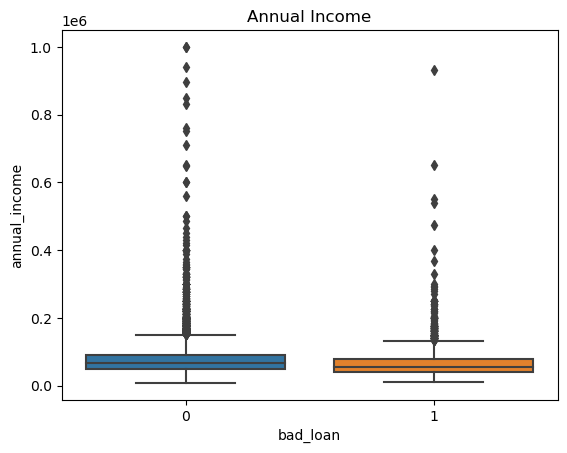

In [47]:
sns.boxplot(y='annual_income',
                x = 'bad_loan', 
                data=df);
plt.title('Annual Income')
plt.show()

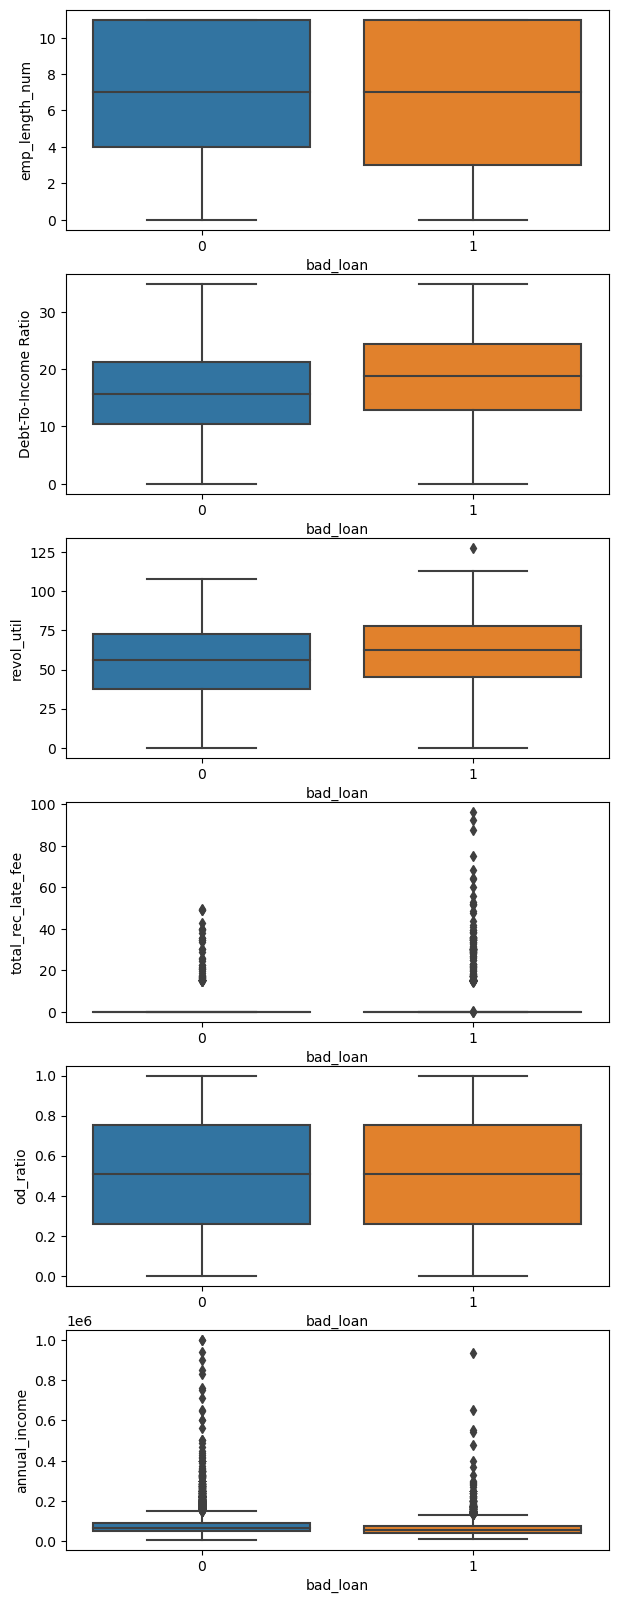

In [48]:
fig,ax = plt.subplots(6,1,figsize=(7,20))

#sns.boxplot(x=df.emp_length_num, y=df.bad_loan, ax=ax[0]);

sns.boxplot(y='emp_length_num',
                x ='bad_loan',
                data=df, 
                ax=ax[0]);

sns.boxplot(y='Debt-To-Income Ratio',
                x='bad_loan',
                data=df, 
                ax=ax[1]);

sns.boxplot(y='revol_util',
                x = 'bad_loan', 
                data=df, 
                ax=ax[2]);

sns.boxplot(y='total_rec_late_fee',
                x = 'bad_loan', 
                data=df, 
                ax=ax[3]);

sns.boxplot(y='od_ratio',
                x = 'bad_loan', 
                data=df, 
                ax=ax[4]);

sns.boxplot(y='annual_income',
                x = 'bad_loan', 
                data=df, 
                ax=ax[5]);

### Data Cleaning - Dealing With Skew

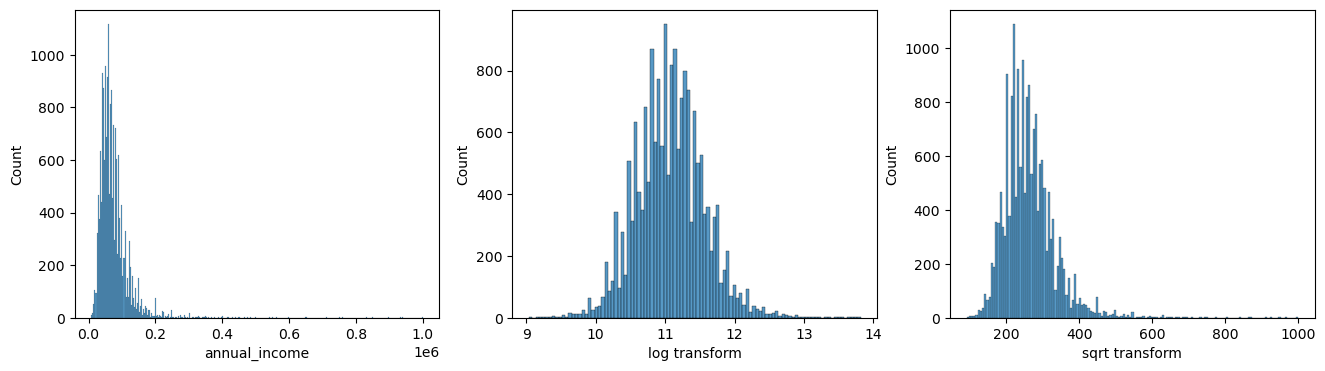

In [49]:
#annual_income looks very skewed. Try trainsforming the feature using log or sqrt


fig, ax = plt.subplots(1, 3, figsize = (16,4))
sns.histplot(x=df.annual_income, ax=ax[0]);
sns.histplot(x=df.annual_income.apply(lambda x: x+1).apply(np.log), ax=ax[1]);
ax[1].set_xlabel('log transform');
sns.histplot(x=df.annual_income.apply(np.sqrt), ax=ax[2]);
ax[2].set_xlabel('sqrt transform');

In [50]:
df['annual_income_log'] = df.annual_income.apply(lambda x: x+1).apply(np.log)

### Feature Engineering - One-Hot Encoding

In [53]:
pd.get_dummies(df).shape

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


(18370, 36)

In [54]:
pd.get_dummies(df).columns

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'annual_income_log', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_36 months', 'term_60 months', 'last_delinq_none_0',
       'last_delinq_none_1'],
      dtype='object')

In [55]:
df = pd.get_dummies(df)

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [56]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

In [57]:
X = df.drop(columns=['id', 'annual_income','bad_loan','grade_A',
                     'home_ownership_MORTGAGE','purpose_car','term_36 months',
                     'last_delinq_none_0'])

y = df['bad_loan'].astype(int)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8)
train_ind, test_ind = next(sss.split(X,y,groups=None))

In [58]:
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

In [59]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [60]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

### XGBoost Classifier

In [61]:
param_grid = [
    {'n_estimators': [100, 200, 300, 400],
     'max_depth': [1, 2, 3, 4, 5],
     'learning_rate': [0.01, 0.1, 1]}
]

xgb_classifier = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'neg_log_loss',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'learning_rate': 0.6, 'max_depth': 1, 'n_estimators': 300}

In [62]:
# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
#     print(mean_score, params)

In [63]:
best_params = grid_search.best_params_

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='logloss',
                                    learning_rate=best_params['learning_rate'],
                                    max_depth=best_params['max_depth'],
                                    n_estimators=best_params['n_estimators'],
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

                #Predicted Negative     Predicted Positive
#Actual Negative       TN                     FP
#Actual Positive       FN                     TP

Confusion Matrix:
[[2936    1]
 [ 731    6]]

Accuracy: 0.8007621121393577

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2937
           1       0.86      0.01      0.02       737

    accuracy                           0.80      3674
   macro avg       0.83      0.50      0.45      3674
weighted avg       0.81      0.80      0.71      3674



In [64]:
#adjust theshold to increase recall for the positive case
threshold = 0.02
y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy：", accuracy)

                #Predicted Negative     Predicted Positive
#Actual Negative       TN                     FP
#Actual Positive       FN                     TP

Confusion Matrix:
[[ 870 2067]
 [ 119  618]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.30      0.44      2937
           1       0.23      0.84      0.36       737

    accuracy                           0.41      3674
   macro avg       0.55      0.57      0.40      3674
weighted avg       0.75      0.41      0.43      3674

Accuracy： 0.4050081654872074


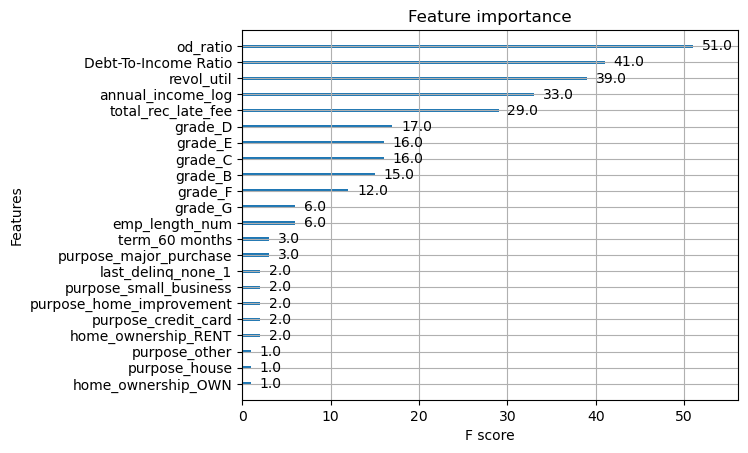

In [65]:
xgb_classifier.get_booster().feature_names =  list(X.columns)
xgb.plot_importance(xgb_classifier);

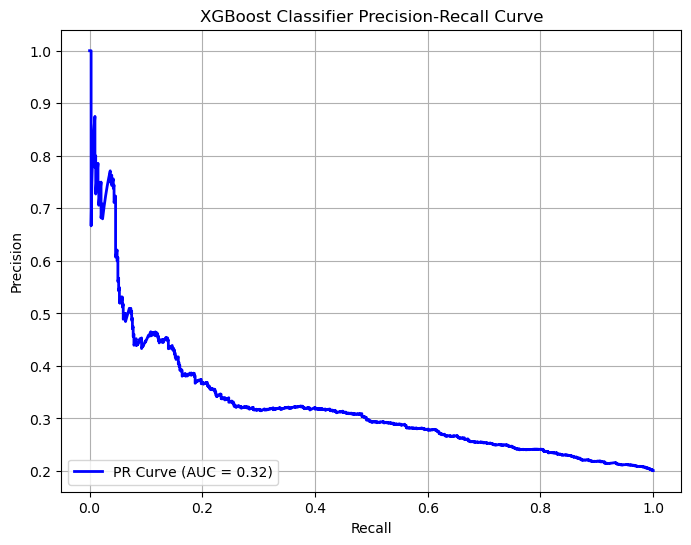

In [66]:
xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(y_test, y_pred_prob)

xgb_pr_auc = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(xgb_recall, xgb_precision, color='b', lw=2, label=f'PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost Classifier Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Random Forest Classifier

In [67]:
param_grid = [
    {'n_estimators': [470, 480, 490],
     'max_depth': [9, 10, 11, 12]}
]

rf_classifier = RandomForestClassifier()

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5,
                          scoring = 'neg_log_loss',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 11, 'n_estimators': 480}

In [68]:
best_params = grid_search.best_params_

rf_classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],  
    max_depth=best_params['max_depth'], 
    class_weight=class_weights,
    random_state = 123
)

rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

y_scores = rf_classifier.predict_proba(X_test)[:, 1]
# threshold = 0.1
# y_pred = (y_scores > threshold).astype(int)

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nRandom Forest Accuracy：", accuracy)

Random Forest Confusion Matrix:
[[2267  670]
 [ 378  359]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      2937
           1       0.35      0.49      0.41       737

    accuracy                           0.71      3674
   macro avg       0.60      0.63      0.61      3674
weighted avg       0.76      0.71      0.73      3674


Random Forest Accuracy： 0.7147523135547088


In [69]:
feature_names = list(X.columns)

In [70]:
for name, score in zip(feature_names, rf_classifier.feature_importances_):
    print(name, score)

short_employee 0.010401820807936035
emp_length_num 0.053690872595837845
Debt-To-Income Ratio 0.17660886707486276
revol_util 0.13137714510124643
total_rec_late_fee 0.03690846054594162
od_ratio 0.10639953852502118
annual_income_log 0.16828547567283422
grade_B 0.03856437081845378
grade_C 0.01597700835102357
grade_D 0.028745412502000953
grade_E 0.02607668979066228
grade_F 0.025056030799824568
grade_G 0.004017093418416464
home_ownership_OWN 0.010410814170292933
home_ownership_RENT 0.02410523501797421
purpose_credit_card 0.012611397253251205
purpose_debt_consolidation 0.012265785272125984
purpose_home_improvement 0.00782566894957333
purpose_house 0.001943031243520112
purpose_major_purchase 0.006931604557502561
purpose_medical 0.002538565205882559
purpose_moving 0.0022045379236260354
purpose_other 0.009186875250719408
purpose_small_business 0.007826078717775558
purpose_vacation 0.0020773802021867124
purpose_wedding 0.0024503238274005846
term_60 months 0.05786382243143564
last_delinq_none_1 0.

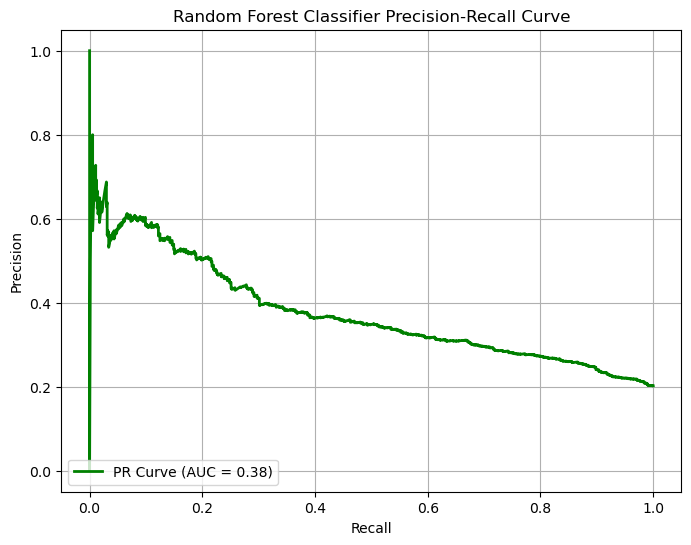

In [71]:
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, y_scores)

rf_pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'PR Curve (AUC = {rf_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Classifier Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Gradient Descent Optimization

Stochastic Gradient Descent

In [72]:
param_grid = [
    {'max_iter': [1000, 1100, 1200, 1300]}
]

sgd_clf = SGDClassifier()

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                          scoring = 'recall',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_iter': 1200}

In [73]:
best_params = grid_search.best_params_

batch_size = 150

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        max_iter = best_params['max_iter'],
                        tol=1e-3,
                        class_weight=class_weights,
                        random_state = 123
                        )

sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)
y_scores = sgd_clf.predict_proba(X_test)[:, 1]
# threshold = 0.5 
# y_pred = (y_scores > threshold).astype(int)

print("SGD Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nSGD Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nSGD Accuracy：", accuracy)


SGD Confusion Matrix:
[[1847 1090]
 [ 275  462]]

SGD Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      2937
           1       0.30      0.63      0.40       737

    accuracy                           0.63      3674
   macro avg       0.58      0.63      0.57      3674
weighted avg       0.76      0.63      0.66      3674


SGD Accuracy： 0.6284703320631464


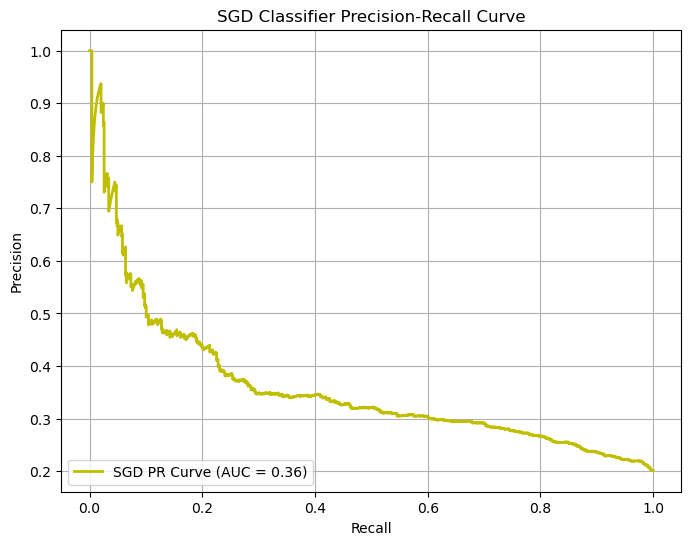

In [74]:
sgd_precision, sgd_recall, sgd_thresholds = precision_recall_curve(y_test, y_scores)

sgd_pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(sgd_recall, sgd_precision, color='y', lw=2, label=f'SGD PR Curve (AUC = {sgd_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SGD Classifier Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Mini-batch Gradient Descent

In [75]:
from sklearn.base import clone

batch_size = 300
samples = len(X_train)

#set aside a validation batch for mini-batch SGD
sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=batch_size, train_size=samples-batch_size)
train_ind, val_ind = next(sss_2.split(X_train, y_train))
X_train_2, y_train_2, X_mini_val, y_mini_val = X_train[list(train_ind)], y_train.iloc[train_ind], X_train[list(val_ind)], y_train.iloc[val_ind]

random_indices = np.random.permutation(len(X_train_2))

sgd_clf = SGDClassifier(loss='log', 
                        max_iter = 1, 
                        learning_rate='constant',
                        eta0 = 0.0005,
                        tol = -np.infty,
                        warm_start = True,
                        penalty = None,
                        class_weight=class_weights,
                        random_state = 123
                        )

minimum_val_error = float("inf") 
best_epoch = None
best_model = None

for epoch in range(100):
    batch_indices_train = random_indices[0: 0 + batch_size]
    X_mini_train, y_mini_train = X_train_2[list(batch_indices_train)], y_train_2.iloc[batch_indices_train]
    sgd_clf.fit(X_mini_train, y_mini_train)
    y_val_pred = sgd_clf.predict(X_mini_val)
    val_error = recall_score(y_mini_val, y_val_pred)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_clf)

sgd_clf = best_model
sgd_clf.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_scores = best_model.predict_proba(X_test)[:, 1]
# threshold = 0.5 
# y_pred = (y_scores > threshold).astype(int)

print("SGD Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nSGD Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nSGD Accuracy：", accuracy)


SGD Confusion Matrix:
[[1855 1082]
 [ 242  495]]

SGD Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.63      0.74      2937
           1       0.31      0.67      0.43       737

    accuracy                           0.64      3674
   macro avg       0.60      0.65      0.58      3674
weighted avg       0.77      0.64      0.67      3674


SGD Accuracy： 0.6396298312465977


In [76]:
best_epoch

40

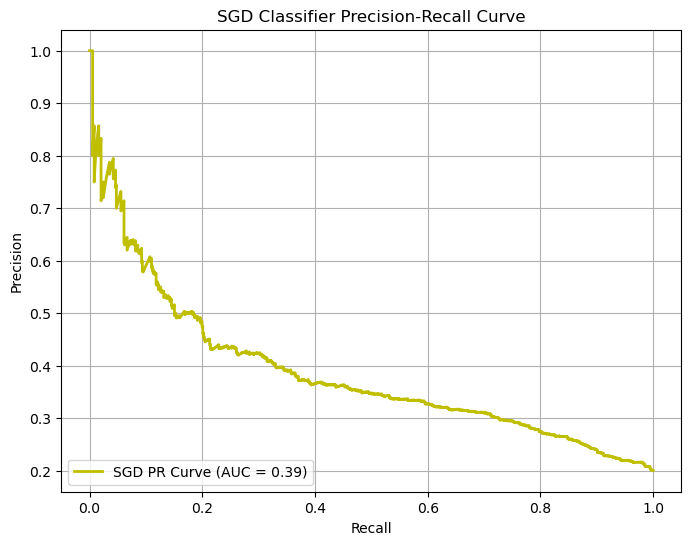

In [77]:
sgd_precision, sgd_recall, sgd_thresholds = precision_recall_curve(y_test, y_scores)

sgd_pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(sgd_recall, sgd_precision, color='y', lw=2, label=f'SGD PR Curve (AUC = {sgd_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SGD Classifier Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Support Vector Machine - Gaussian RBF Kernel

Linear SVM

In [78]:
param_grid = [
    {'max_iter': [1000, 2000, 3000],
     'C': [0.001, 0.1, 1, 10]}
]

lin_svm_clf = LinearSVC(dual=False)

grid_search = GridSearchCV(lin_svm_clf, param_grid, cv=5,
                          scoring = 'recall',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 0.1, 'max_iter': 1000}

In [79]:
best_params = grid_search.best_params_

lin_svm_clf = LinearSVC(dual=False,
                        C=best_params['C'], 
                        loss='squared_hinge', 
                        max_iter = best_params['max_iter'], 
                        random_state=123)

lin_svm_clf.fit(X_train, y_train)
y_pred = lin_svm_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy：", accuracy)

                #Predicted Negative     Predicted Positive
#Actual Negative       TN                     FP
#Actual Positive       FN                     TP

Confusion Matrix:
[[2926   11]
 [ 695   42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      2937
           1       0.79      0.06      0.11       737

    accuracy                           0.81      3674
   macro avg       0.80      0.53      0.50      3674
weighted avg       0.80      0.81      0.73      3674


Accuracy： 0.8078388677191073


Polynomial Kernel Support Vector Classifier

In [86]:
param_grid = [
    {'degree': [3, 4],
     'coef0': [1, 2],
     'C': [1, 100]}
]

poly_kernel_svm_clf = SVC(kernel = 'poly')

grid_search = GridSearchCV(poly_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'recall',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 100, 'coef0': 2, 'degree': 4}

In [87]:
#best_params = grid_search.best_params_

poly_kernel_svm_clf = SVC(kernel = 'poly',
                          degree = 3,
                          coef0 = 1,
                          C = 1,
                          probability = True,
                          class_weight=class_weights)

poly_kernel_svm_clf.fit(X_train, y_train)
y_pred = poly_kernel_svm_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy：", accuracy)

                #Predicted Negative     Predicted Positive
#Actual Negative       TN                     FP
#Actual Positive       FN                     TP

Confusion Matrix:
[[1971  966]
 [ 303  434]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.67      0.76      2937
           1       0.31      0.59      0.41       737

    accuracy                           0.65      3674
   macro avg       0.59      0.63      0.58      3674
weighted avg       0.76      0.65      0.69      3674


Accuracy： 0.6545998911268373


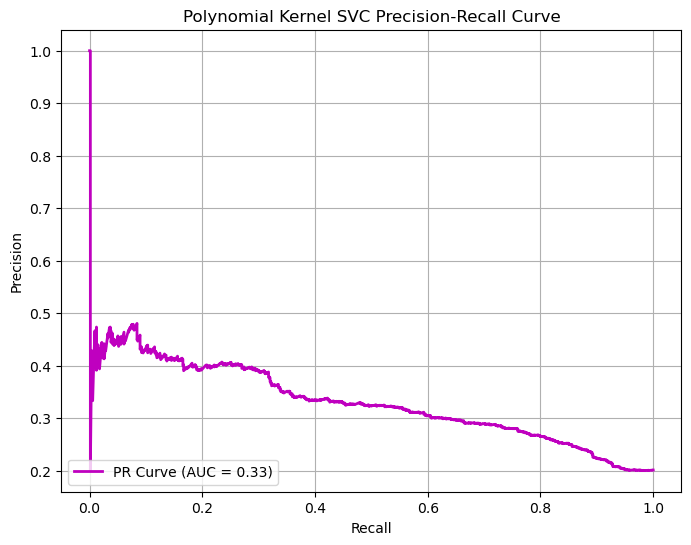

In [88]:
y_scores = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

poly_kernel_svm_precision, poly_kernel_svm_recall, thresholds = precision_recall_curve(y_test, y_scores)

poly_kernel_svm_pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(poly_kernel_svm_recall, poly_kernel_svm_precision, color='m', lw=2, label=f'PR Curve (AUC = {poly_kernel_svm_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Polynomial Kernel SVC Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Gaussian RBF Kernel Support Vector Classifier

In [89]:
param_grid = [
    {'gamma': [0.01, 0.1, 1],
     'C': [1, 10, 100]}
]

rbf_kernel_svm_clf = SVC(kernel = 'rbf')

grid_search = GridSearchCV(rbf_kernel_svm_clf, param_grid, cv=3,
                          scoring = 'recall',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 100, 'gamma': 0.1}

In [90]:
best_params = grid_search.best_params_

#https://scikit-learn.org/stable/modules/svm.html#svm-kernels

rbf_kernel_svm_clf = SVC(kernel = 'rbf',
                         gamma = best_params['gamma'],
                         C = best_params['C'],
                         probability = True,
                         class_weight=class_weights)

rbf_kernel_svm_clf.fit(X_train, y_train)
y_pred = rbf_kernel_svm_clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy：", accuracy)

                #Predicted Negative     Predicted Positive
#Actual Negative       TN                     FP
#Actual Positive       FN                     TP

Confusion Matrix:
[[2235  702]
 [ 488  249]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      2937
           1       0.26      0.34      0.30       737

    accuracy                           0.68      3674
   macro avg       0.54      0.55      0.54      3674
weighted avg       0.71      0.68      0.69      3674


Accuracy： 0.6761023407729995


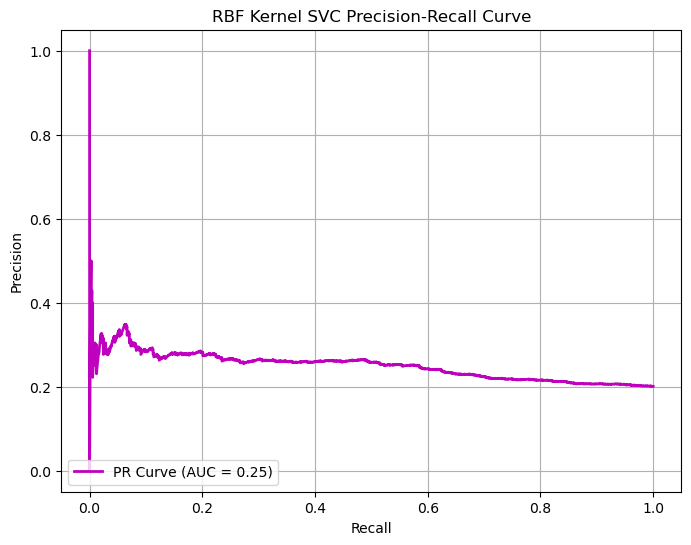

In [91]:
y_scores = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

rbf_kernel_svm_precision, rbf_kernel_svm_recall, thresholds = precision_recall_curve(y_test, y_scores)

rbf_kernel_svm_pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(rbf_kernel_svm_recall, rbf_kernel_svm_precision, color='m', lw=2, label=f'PR Curve (AUC = {rbf_kernel_svm_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RBF Kernel SVC Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Stacking/Stacked Generalization

In [94]:
base_learners = [
    ('rf', rf_classifier),
    ('sgd', sgd_clf),
    ('xgb', xgb_classifier),
]

meta_learner = LogisticRegression(class_weight=class_weights)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)

y_pred_prob = stacking_model.predict_proba(X_test)[:, 1]
# threshold = 0.5 
# y_pred = (y_pred_prob >= threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy：", accuracy)

Confusion Matrix:
[[1991  946]
 [ 297  440]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      2937
           1       0.32      0.60      0.41       737

    accuracy                           0.66      3674
   macro avg       0.59      0.64      0.59      3674
weighted avg       0.76      0.66      0.69      3674


Accuracy： 0.6616766467065869


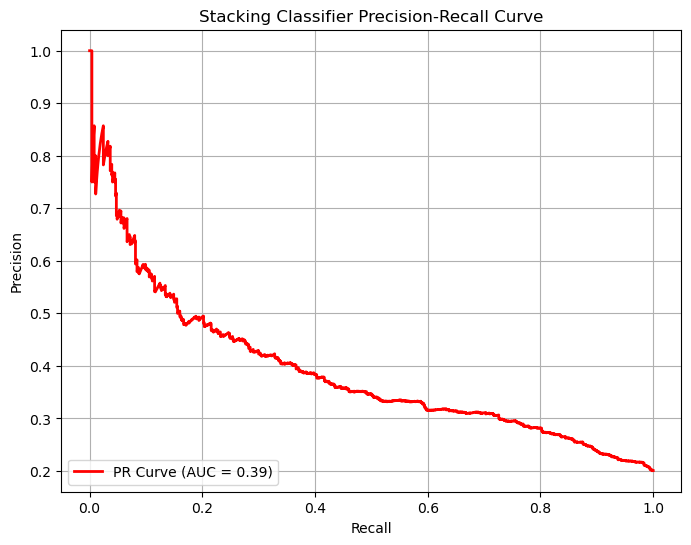

In [95]:
stacking_precision, stacking_recall, stacking_thresholds = precision_recall_curve(y_test, y_pred_prob)

stacking_pr_auc = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(stacking_recall, stacking_precision, color='r', lw=2, label=f'PR Curve (AUC = {stacking_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Stacking Classifier Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

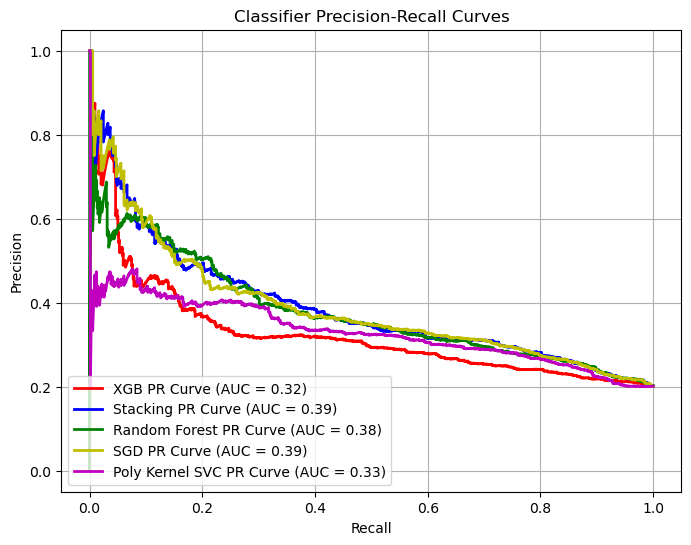

In [96]:
plt.figure(figsize=(8, 6))
plt.plot(xgb_recall, xgb_precision, color='r', lw=2, label=f'XGB PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.plot(stacking_recall, stacking_precision, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stacking_pr_auc:.2f})')
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_pr_auc:.2f})')
plt.plot(sgd_recall, sgd_precision, color='y', lw=2, label=f'SGD PR Curve (AUC = {sgd_pr_auc:.2f})')
plt.plot(poly_kernel_svm_recall, poly_kernel_svm_precision, color='m', lw=2, label=f'Poly Kernel SVC PR Curve (AUC = {poly_kernel_svm_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Classifier Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()